In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy as copy
sns.set()

%matplotlib inline

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

### functions

In [2]:
def load_joke(file):
    f = open(file,'r')
    
    data = []
    ind = 0
    for line in f:
        converted_line = ([np.float(i) for i in list(line.strip('\n').strip('').split(','))])
        data.append(converted_line)

    data = np.array(data)
    f.close()
    return data

def convert_jokes_matrix(data):
    users = np.unique(data[:,0]).astype(int) - 1
    num_people = np.max(users) + 1

    jokes = np.unique(data[:,1]).astype(int) - 1
    num_jokes = np.max(jokes) + 1

    R_matrix = np.zeros((num_people,num_jokes))
    R_matrix = np.nan*R_matrix

    for i in np.arange(data.shape[0]):
        R_matrix[int(data[i,0])-1,int(data[i,1])-1] = data[i,2]
        
    return R_matrix,users,jokes



def mean_square_error(predict,test):
    #num_entries = test.shape[0]*test.shape[1]
    num_entries =np.sum(np.sum(~np.isnan(test),axis=1))
    diff_predict_test = (predict - test)**2 
    error = (1/num_entries)*np.nansum(np.nansum(diff_predict_test))
    return error

def mean_absolute_error(predict,test):
    num_users = test.shape[0]
    num_test_moves_peruser = np.sum(~np.isnan(test),axis=1)
    diff_predict_test = np.abs(predict - test)
    
    movies_by_user_sum = np.nansum(diff_predict_test,axis=1)
    movies_by_user_weighted = 1/num_test_moves_peruser * movies_by_user_sum 
    
    error = (1/num_users) * np.sum(movies_by_user_weighted)
    return error

def matrix_mult_nan(vector,data):
    output = np.zeros((vector.shape[0],data.shape[1]))
    
    for i in np.arange(output.shape[0]):
        for j in np.arange(output.shape[1]):
            #import pdb;pdb.set_trace()
            output[i,j] = np.nansum(vector[i,:]*data[:,j])
    
    
    return output


def alternate_minimization(d,lambda_val):
    u = np.random.randn(len(users),d)
    v = np.random.randn(len(jokes),d)

    not_conv = 1
    iteration = 1
    while not_conv:

        lhs = (np.dot(v.T,v) + lambda_val*np.identity(d))
        rhs = matrix_mult_nan(v.T,training_R.T)
        #import pdb;pdb.set_trace()
        u = np.linalg.solve(lhs,rhs)
        u = u.T
        
        lhs = (np.dot(u.T,u) + lambda_val*np.identity(d))
        rhs = matrix_mult_nan(u.T,training_R)

        v = np.linalg.solve(lhs,rhs)
        
        v = v.T

        if iteration > 20:
            not_conv = 0
        print(iteration)
        iteration += 1 
        
    return u,v


def alternate_minimize_overall(training_R,testing_R,d_vec,lambda_vec):

    cost_vec = np.zeros((lambda_vec.shape[0],d_vec.shape[0]))

    lambda_iter = 0



    for lambda_val in lambda_vec:
        d_iter = 0


        mae_training_vec = []
        mse_training_vec = []
        mae_testing_vec = []
        mse_testing_vec = []

        for d in d_vec:
            score_ind = []


            u,v = alternate_minimization(d,lambda_val)
            R_ij_predict = np.dot(u,v.T)

            mse_test = mean_square_error(R_ij_predict,testing_R)
            print('The mean squared error for using matrix factorization with d = {}, lambda = {}, for prediction on the test set is {:.2f}'.format(d,lambda_val,mse_test))
            mae_test = mean_absolute_error(R_ij_predict,testing_R)
            print('The mean absolute error for matrix factorization with d = {}, lambda = {}, for prediction on the test set is {:.2f}'.format(d,lambda_val,mae_test))
            mse_train = mean_square_error(R_ij_predict,training_R)
            print('The mean squared error for matrix factorization with d = {}, lambda = {}, for prediction on the train set is {:.2f}'.format(d,lambda_val,mse_train))
            mae_train = mean_absolute_error(R_ij_predict,training_R)
            print('The mean absolute error for matrix factorization with d = {}, lambda = {}, for prediction on the train set is {:.2f}'.format(d,lambda_val,mae_test))

            mae_training_vec.append(mae_train)
            mse_training_vec.append(mse_train)
            mae_testing_vec.append(mae_test)
            mse_testing_vec.append(mse_test)

            cost_vec[lambda_iter][d_iter] = mae_test

            d_iter += 1

        lambda_iter +=1 

        plotIt = False
        if plotIt:
            plt.figure(dpi=600)
            plt.xlabel('d')
            plt.ylabel('error metric')
            plt.plot(d_vec,mae_training_vec,label='mean absolute error on training')
            plt.plot(d_vec,mae_testing_vec,label='mean absolute error on testing')
            plt.plot(d_vec,mse_training_vec,label='mean squared error on training')
            plt.plot(d_vec,mse_testing_vec,label='mean squared error on testing')
            plt.title('Error for prediction from matrix factorization, lambda = {}'.format(lambda_val))
            plt.legend()

    return cost_vec




### load in the data from the .txt files

In [3]:
training = load_joke('./jester/train.txt')
testing = load_joke('./jester/test.txt')

### convert it to matrix form

In [4]:
training_R,users,jokes = convert_jokes_matrix(training)
testing_R,_,_ = convert_jokes_matrix(testing)

### perform prediction via average 

In [7]:
training_R_zeros = copy.copy(training_R)
training_R_zeros[np.isnan(training_R_zeros)] = 0

testing_R_zeros = copy.copy(testing_R)
testing_R_zeros[np.isnan(testing_R_zeros)] = 0

users_ones = np.ones((users.shape[0],1))
movie_averaged = np.nanmean(training_R,axis=0)

movie_averaged = np.expand_dims(movie_averaged,axis=1)

R_ij_predict = np.dot(users_ones,movie_averaged.T)

training_user_average = np.nanmean(training_R,axis=1)
training_R_no_user_avg = (training_R.T - training_user_average).T

R_ij_predict = (R_ij_predict.T + training_user_average).T


In [8]:
mse = mean_square_error(R_ij_predict,testing_R)
print('The mean squared error for using the average score for prediction on the test set is {:.2f}'.format(mse))

mae = mean_absolute_error(R_ij_predict,testing_R)
print('The mean absolute error for using the average score for prediction on the test set is {:.2f}'.format(mae))

mse = mean_square_error(R_ij_predict,training_R)
print('The mean squared error for using the average score for prediction on the train set is {:.2f}'.format(mse))

mae = mean_absolute_error(R_ij_predict,training_R)
print('The mean absolute error for using the average score for prediction on the train set is {:.2f}'.format(mae))

The mean squared error for using the average score for prediction on the test set is 19.91
The mean absolute error for using the average score for prediction on the test set is 3.48
The mean squared error for using the average score for prediction on the train set is 18.84
The mean absolute error for using the average score for prediction on the train set is 3.38


### averaging part 

In [57]:
users_ones = np.ones((users.shape[0],1))

movie_averaged = np.mean(training_R_no_user_avg,axis=0)

movie_averaged = np.expand_dims(movie_averaged,axis=1)


R_ij_predict = np.dot(users_ones,movie_averaged.T)

prediction = (R_ij_predict.T + training_user_average).T



### SVD 

The mean squared error for using the SVD with d = 1 for prediction on the test set is 19.66
The mean absolute error for using the SVD with d = 1 for prediction on the test set is 3.53
The mean squared error for using the SVD with d = 1 prediction on the train set is 18.00
The mean absolute error for using the SVD with d = 1 for prediction on the train set is 3.53
The mean squared error for using the SVD with d = 2 for prediction on the test set is 19.34
The mean absolute error for using the SVD with d = 2 for prediction on the test set is 3.50
The mean squared error for using the SVD with d = 2 prediction on the train set is 17.19
The mean absolute error for using the SVD with d = 2 for prediction on the train set is 3.50
The mean squared error for using the SVD with d = 5 for prediction on the test set is 18.93
The mean absolute error for using the SVD with d = 5 for prediction on the test set is 3.45
The mean squared error for using the SVD with d = 5 prediction on the train set is 1

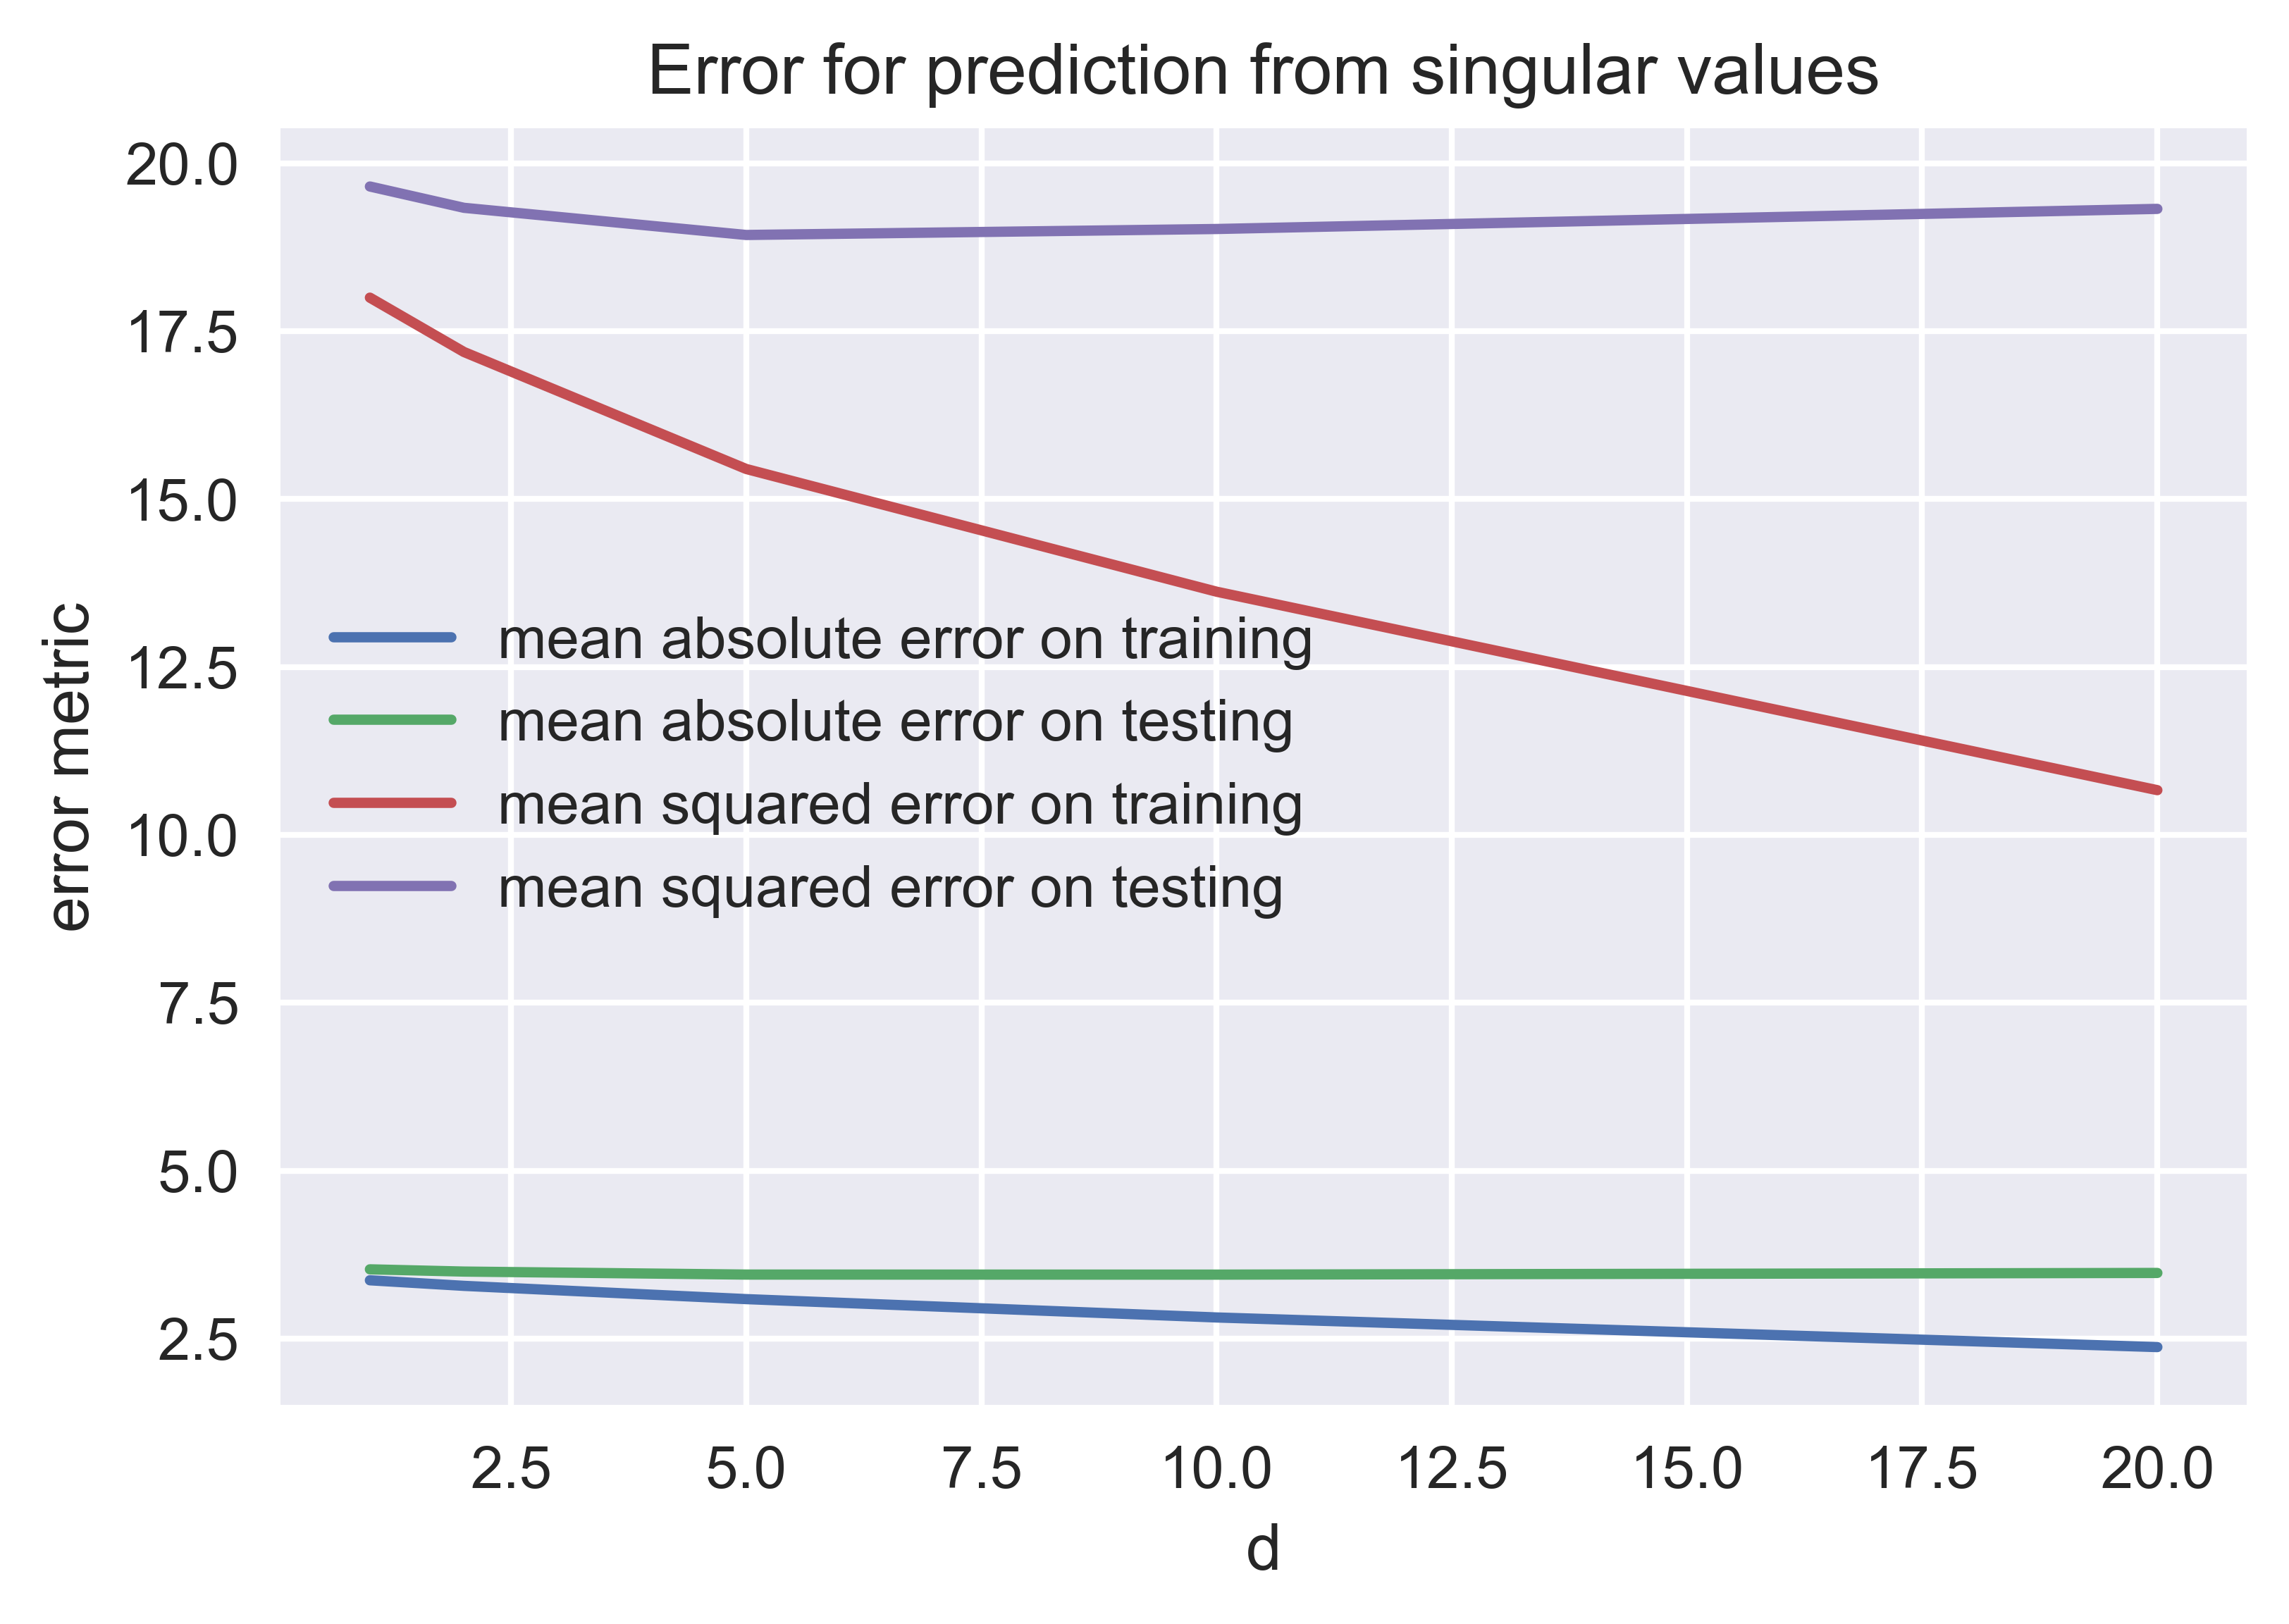

In [9]:
d_vec = [1,2,5,10,20]

mae_training_vec = []
mse_training_vec = []
mae_testing_vec = []
mse_testing_vec = []

avg = True

if avg:
    #user_averaged = np.expand_dims(np.nanmean(training_R_zeros,axis=1),axis=1)
    user_averaged = np.expand_dims(np.nanmean(training_R,axis=1),axis=1)

    training_R_zeros = copy.copy(training_R)
    training_R_zeros[np.isnan(training_R_zeros)] = 0

    #training_R_zeros_meanSub = training_R_zeros - user_averaged
    training_R_zeros_meanSub = training_R - user_averaged 
    training_R_zeros_meanSub[np.isnan(training_R_zeros_meanSub)] = 0

# use training_R_zeros

for d in d_vec:

    if avg:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros_meanSub,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))
        R_ij_predict = R_ij_predict + user_averaged
    else:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))

    
    mse_test = mean_square_error(R_ij_predict,testing_R)
    print('The mean squared error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mse_test))
    mae_test = mean_absolute_error(R_ij_predict,testing_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mae_test))
    mse_train = mean_square_error(R_ij_predict,training_R)
    print('The mean squared error for using the SVD with d = {} prediction on the train set is {:.2f}'.format(d,mse_train))
    mae_train = mean_absolute_error(R_ij_predict,training_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the train set is {:.2f}'.format(d,mae_test))
    
    mae_training_vec.append(mae_train)
    mse_training_vec.append(mse_train)
    mae_testing_vec.append(mae_test)
    mse_testing_vec.append(mse_test)
    
plt.figure(dpi=600)
plt.xlabel('d')
plt.ylabel('error metric')
plt.plot(d_vec,mae_training_vec,label='mean absolute error on training')
plt.plot(d_vec,mae_testing_vec,label='mean absolute error on testing')
plt.plot(d_vec,mse_training_vec,label='mean squared error on training')
plt.plot(d_vec,mse_testing_vec,label='mean squared error on testing')
plt.title('Error for prediction from singular values')
plt.legend()

The mean squared error for using the SVD with d = 1 for prediction on the test set is 23.15
The mean absolute error for using the SVD with d = 1 for prediction on the test set is 4.02
The mean squared error for using the SVD with d = 1 prediction on the train set is 22.59
The mean absolute error for using the SVD with d = 1 for prediction on the train set is 4.02
The mean squared error for using the SVD with d = 2 for prediction on the test set is 21.45
The mean absolute error for using the SVD with d = 2 for prediction on the test set is 3.87
The mean squared error for using the SVD with d = 2 prediction on the train set is 20.37
The mean absolute error for using the SVD with d = 2 for prediction on the train set is 3.87
The mean squared error for using the SVD with d = 5 for prediction on the test set is 20.52
The mean absolute error for using the SVD with d = 5 for prediction on the test set is 3.78
The mean squared error for using the SVD with d = 5 prediction on the train set is 1

Text(0.5,0,'d')

Text(0,0.5,'error metric')

Text(0.5,1,'Error for prediction from singular values')

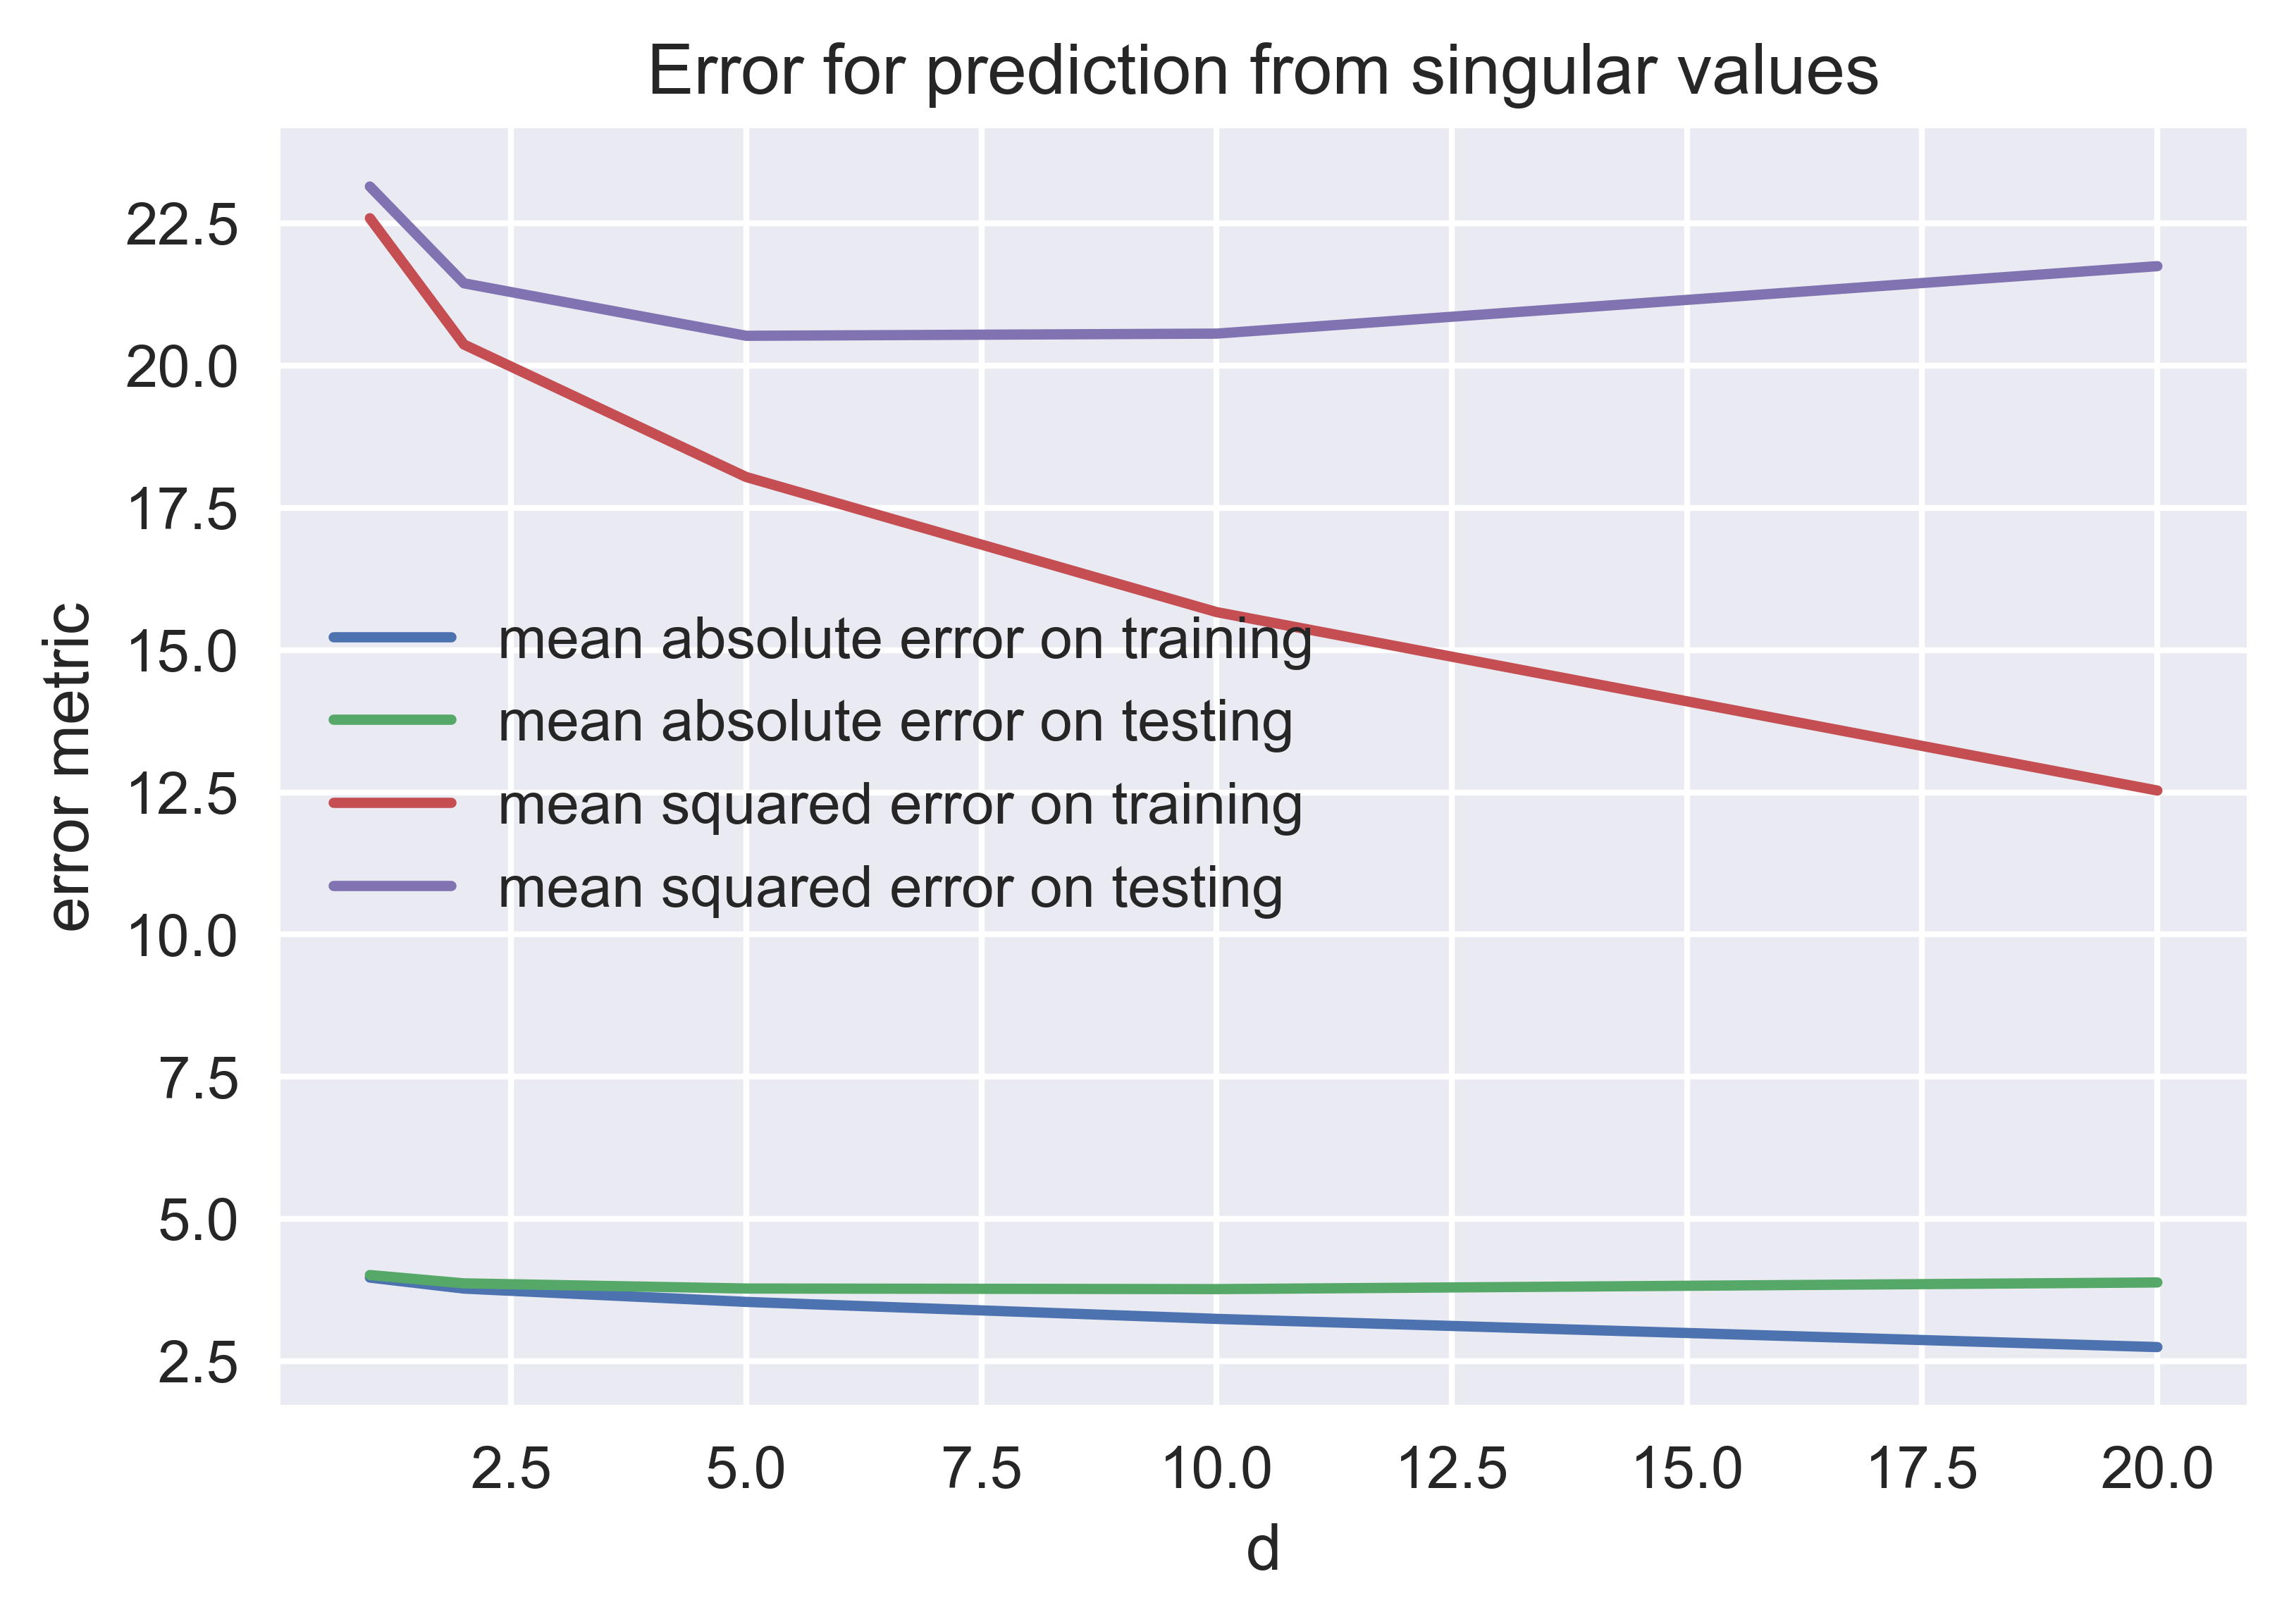

In [157]:
d_vec = [1,2,5,10,20]

mae_training_vec = []
mse_training_vec = []
mae_testing_vec = []
mse_testing_vec = []

avg = False

if avg:
    user_averaged = np.expand_dims(np.mean(training_R_zeros,axis=1),axis=1)

    training_R_zeros_meanSub = training_R_zeros - user_averaged

# use training_R_zeros

for d in d_vec:

    if avg:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros_meanSub,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))
        R_ij_predict = R_ij_predict + user_averaged
    else:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))

    
    mse_test = mean_square_error(R_ij_predict,testing_R)
    print('The mean squared error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mse_test))
    mae_test = mean_absolute_error(R_ij_predict,testing_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mae_test))
    mse_train = mean_square_error(R_ij_predict,training_R)
    print('The mean squared error for using the SVD with d = {} prediction on the train set is {:.2f}'.format(d,mse_train))
    mae_train = mean_absolute_error(R_ij_predict,training_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the train set is {:.2f}'.format(d,mae_test))
    
    mae_training_vec.append(mae_train)
    mse_training_vec.append(mse_train)
    mae_testing_vec.append(mae_test)
    mse_testing_vec.append(mse_test)
    
plt.figure(dpi=600)
plt.xlabel('d')
plt.ylabel('error metric')
plt.plot(d_vec,mae_training_vec,label='mean absolute error on training')
plt.plot(d_vec,mae_testing_vec,label='mean absolute error on testing')
plt.plot(d_vec,mse_training_vec,label='mean squared error on training')
plt.plot(d_vec,mse_testing_vec,label='mean squared error on testing')
plt.title('Error for prediction from singular values')
plt.legend()

### alternating minimization

In [201]:
d_vec = np.array([1,2,5,10,20])
lambda_vec = np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])
cost_vec = alternate_minimize_overall(training_R,testing_R,d_vec,lambda_vec)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 1, lambda = 1e-06, for prediction on the test set is 23.15
The mean absolute error for matrix factorization with d = 1, lambda = 1e-06, for prediction on the test set is 4.02
The mean squared error for matrix factorization with d = 1, lambda = 1e-06, for prediction on the train set is 22.59
The mean absolute error for matrix factorization with d = 1, lambda = 1e-06, for prediction on the train set is 4.02
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 2, lambda = 1e-06, for prediction on the test set is 21.45
The mean absolute error for matrix factorization with d = 2, lambda = 1e-06, for prediction on the test set is 3.87
The mean squared error for matrix factorization with d = 2, lambda = 1e-06, for prediction on the train set is 20.37
The mean absolute error for matrix factorization with d = 2, lamb

The mean absolute error for matrix factorization with d = 1, lambda = 0.001, for prediction on the train set is 4.02
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 2, lambda = 0.001, for prediction on the test set is 21.45
The mean absolute error for matrix factorization with d = 2, lambda = 0.001, for prediction on the test set is 3.87
The mean squared error for matrix factorization with d = 2, lambda = 0.001, for prediction on the train set is 20.37
The mean absolute error for matrix factorization with d = 2, lambda = 0.001, for prediction on the train set is 3.87
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 5, lambda = 0.001, for prediction on the test set is 20.53
The mean absolute error for matrix factorization with d = 5, lambda = 0.001, for prediction on the test set is 3.78
The mean squared error for matrix factorization with d = 5, lambd

The mean absolute error for matrix factorization with d = 2, lambda = 1.0, for prediction on the train set is 3.87
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 5, lambda = 1.0, for prediction on the test set is 20.53
The mean absolute error for matrix factorization with d = 5, lambda = 1.0, for prediction on the test set is 3.78
The mean squared error for matrix factorization with d = 5, lambda = 1.0, for prediction on the train set is 18.04
The mean absolute error for matrix factorization with d = 5, lambda = 1.0, for prediction on the train set is 3.78
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 10, lambda = 1.0, for prediction on the test set is 20.58
The mean absolute error for matrix factorization with d = 10, lambda = 1.0, for prediction on the test set is 3.77
The mean squared error for matrix factorization with d = 10, lambda = 1.0, fo

In [194]:
best_ind

(6, 3)

In [193]:
d_vec.shape

(5,)

In [196]:
best_d

10

In [199]:
best_lambda

1.0

In [200]:
lambda_vec

array([  1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00])

In [198]:
best_ind = np.unravel_index(cost_vec.argmin(), cost_vec.shape)

best_d = d_vec[best_ind[1]]
best_lambda = lambda_vec[best_ind[0]]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 1, lambda = 1.0, for prediction on the test set is 23.15
The mean absolute error for matrix factorization with d = 1, lambda = 1.0, for prediction on the test set is 4.02
The mean squared error for matrix factorization with d = 1, lambda = 1.0, for prediction on the train set is 22.59
The mean absolute error for matrix factorization with d = 1, lambda = 1.0, for prediction on the train set is 4.02
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
The mean squared error for using matrix factorization with d = 2, lambda = 1.0, for prediction on the test set is 21.45
The mean absolute error for matrix factorization with d = 2, lambda = 1.0, for prediction on the test set is 3.87
The mean squared error for matrix factorization with d = 2, lambda = 1.0, for prediction on the train set is 20.37
The mean absolute error for matrix factorization with d = 2, lambda = 1.0, for 

Text(0.5,0,'d')

Text(0,0.5,'error metric')

Text(0.5,1,'Error for prediction from matrix factorization, lambda = 1.0')

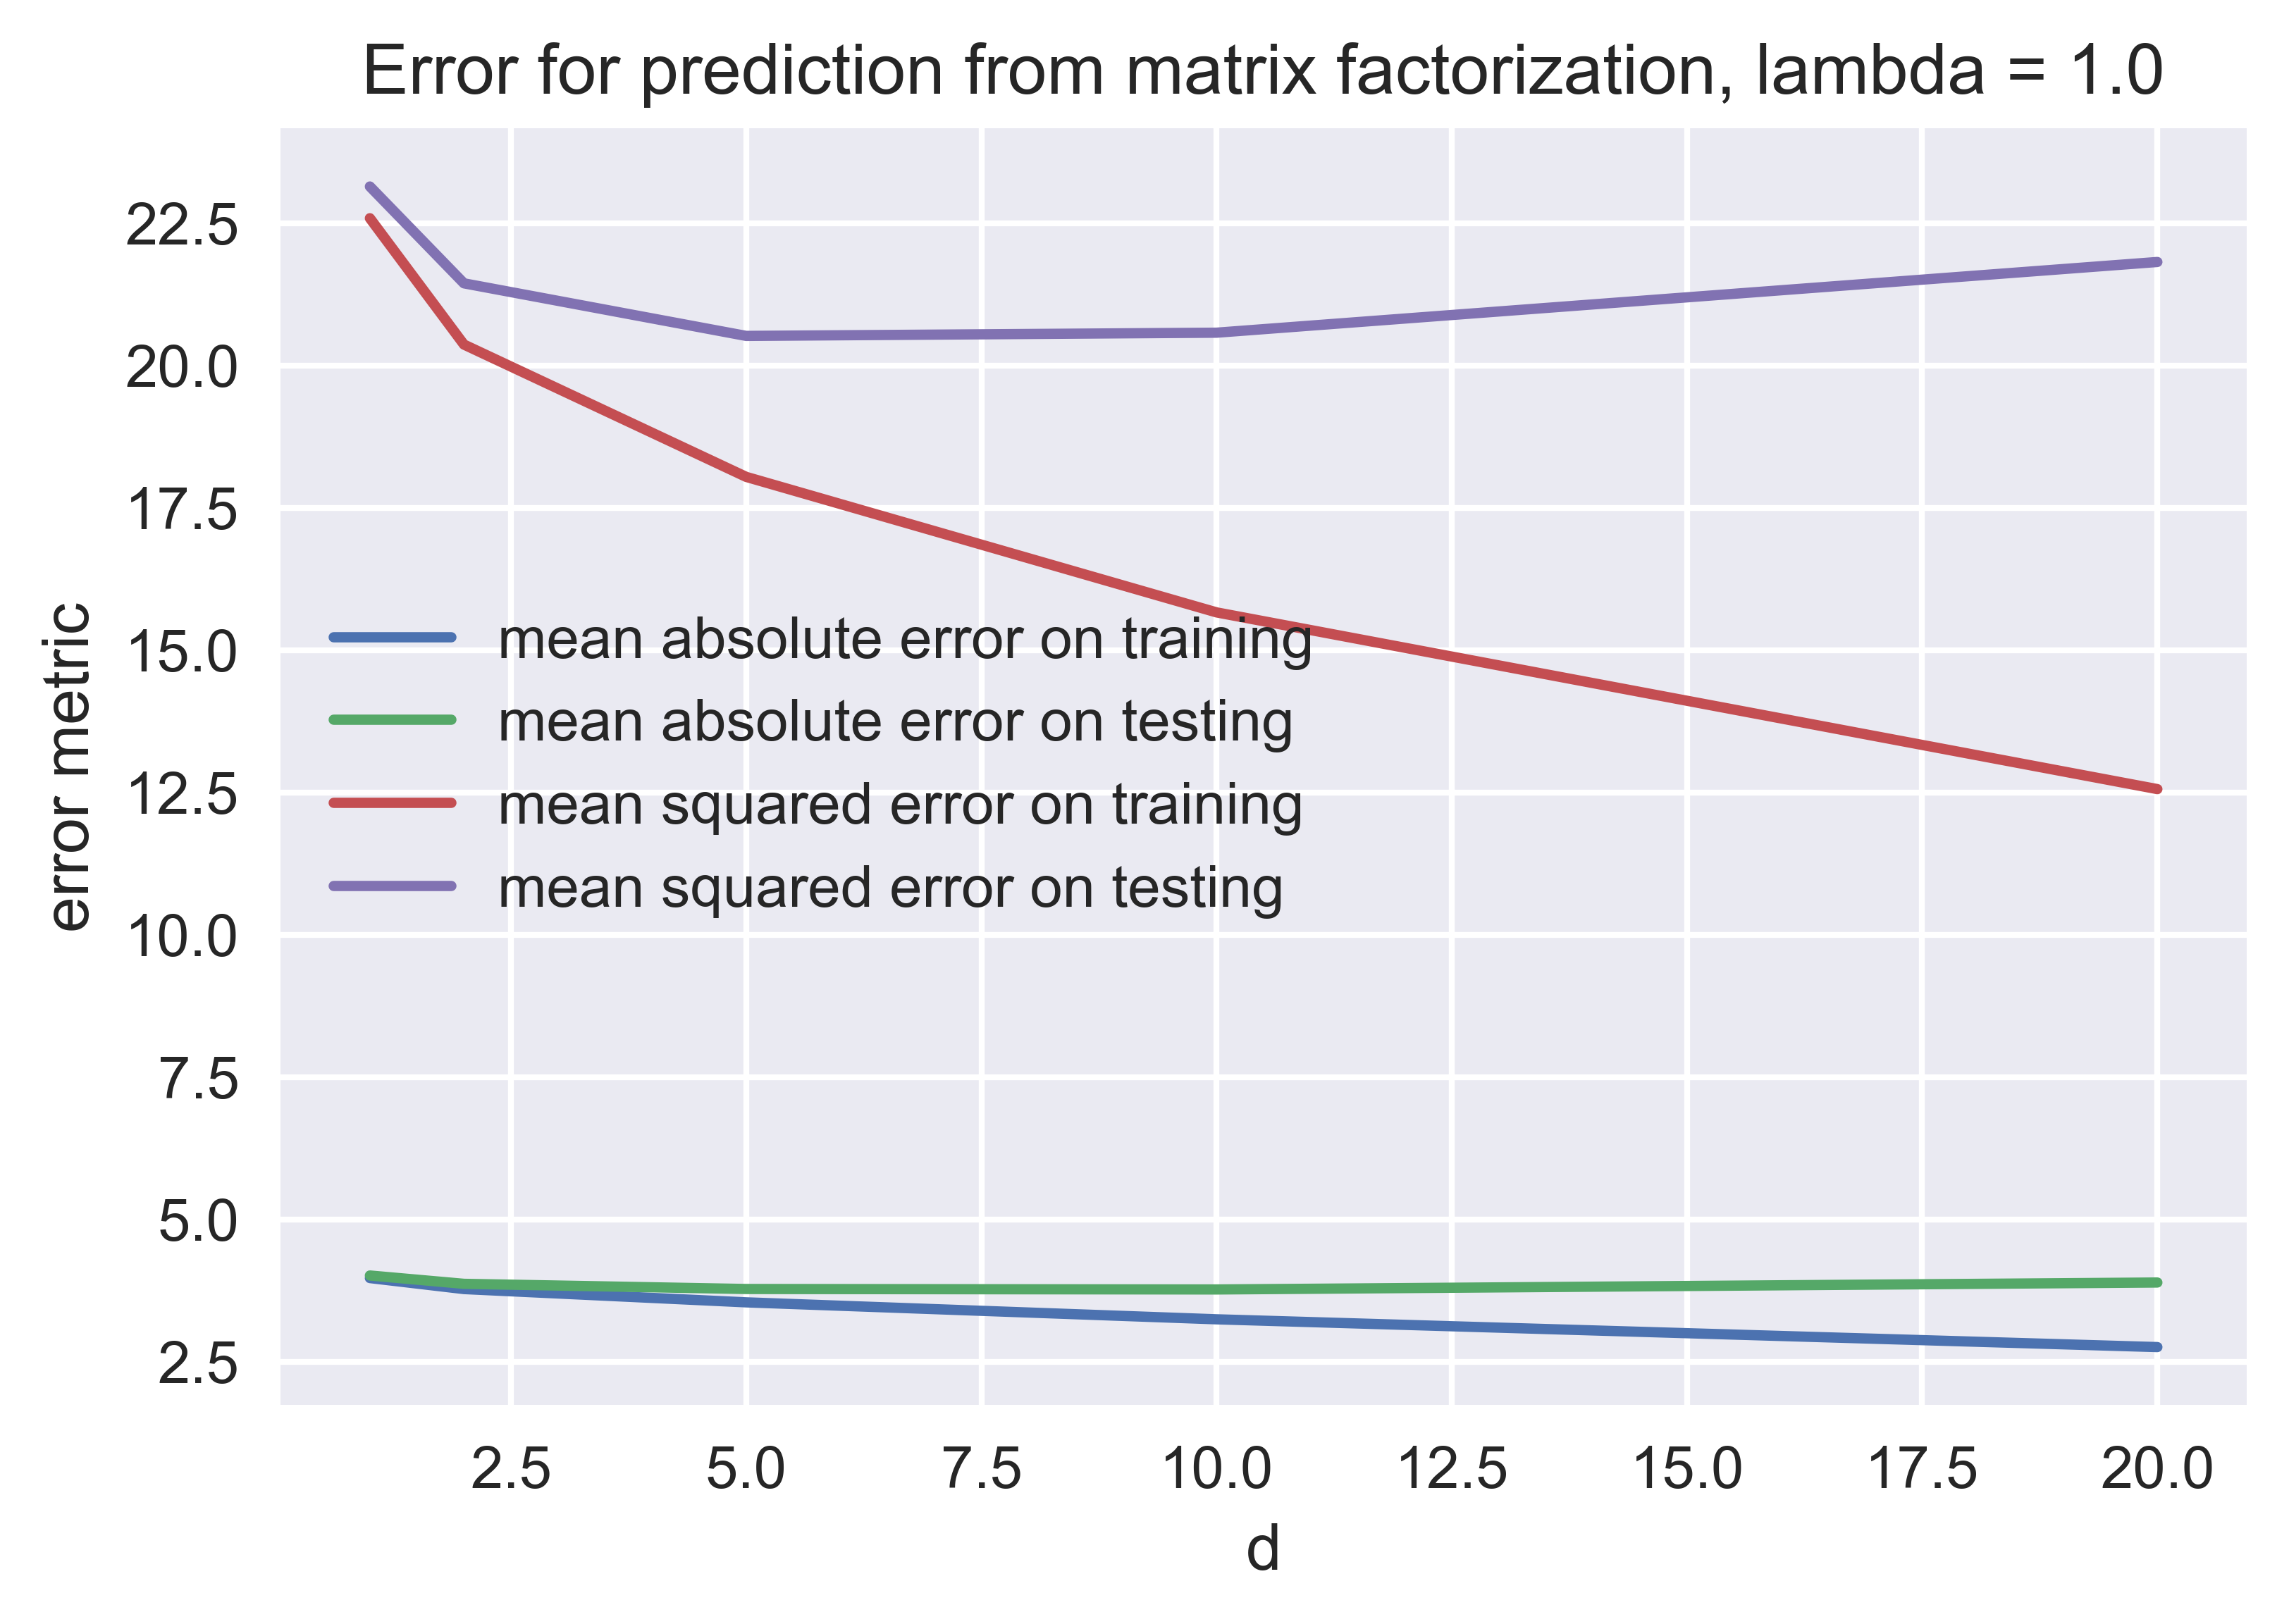

In [192]:
d_vec = np.array([1,2,5,10,20])


mae_training_vec = []
mse_training_vec = []
mae_testing_vec = []
mse_testing_vec = []

for d in d_vec:
    score_ind = []


    u,v = alternate_minimization(d,best_lambda)
    R_ij_predict = np.dot(u,v.T)

    mse_test = mean_square_error(R_ij_predict,testing_R)
    print('The mean squared error for using matrix factorization with d = {}, lambda = {}, for prediction on the test set is {:.2f}'.format(d,best_lambda,mse_test))
    mae_test = mean_absolute_error(R_ij_predict,testing_R)
    print('The mean absolute error for matrix factorization with d = {}, lambda = {}, for prediction on the test set is {:.2f}'.format(d,best_lambda,mae_test))
    mse_train = mean_square_error(R_ij_predict,training_R)
    print('The mean squared error for matrix factorization with d = {}, lambda = {}, for prediction on the train set is {:.2f}'.format(d,best_lambda,mse_train))
    mae_train = mean_absolute_error(R_ij_predict,training_R)
    print('The mean absolute error for matrix factorization with d = {}, lambda = {}, for prediction on the train set is {:.2f}'.format(d,best_lambda,mae_test))

    mae_training_vec.append(mae_train)
    mse_training_vec.append(mse_train)
    mae_testing_vec.append(mae_test)
    mse_testing_vec.append(mse_test)
    
plotIt = True
if plotIt:
    plt.figure(dpi=600)
    plt.xlabel('d')
    plt.ylabel('error metric')
    plt.plot(d_vec,mae_training_vec,label='mean absolute error on training')
    plt.plot(d_vec,mae_testing_vec,label='mean absolute error on testing')
    plt.plot(d_vec,mse_training_vec,label='mean squared error on training')
    plt.plot(d_vec,mse_testing_vec,label='mean squared error on testing')
    plt.title('Error for prediction from matrix factorization, lambda = {}'.format(best_lambda))
    plt.legend()

    #plt.savefig('longer_run')
